<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/02_LangGraph_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install langgraph langchain_groq langchain

Tool Management

In [8]:
def add_two_number(a:int,b:int) -> int:
    """
    This function add two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Sum of two valus
    """
    int_a = int(a)
    int_b = int(b)

    return int_a+int_b

Model

In [9]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

LLM With Tools

In [10]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    api_key= userdata.get("groq_key")
)

llm_bind_tools = llm.bind_tools([add_two_number])

Invoke LLM

In [11]:
invoke_llm = llm_bind_tools.invoke("add two_numbe 2 and 5")

In [12]:
invoke_llm.tool_calls

[{'name': 'add_two_number',
  'args': {'a': 2, 'b': 5},
  'id': 'tsxezs990',
  'type': 'tool_call'}]

LangGraph Tool Calling

In [13]:
def llm_tool_calling(state: State) -> State:
    """
    This function is called to invoke the LLM with tools.

    :param state: The current state containing messages
    :return: Updated state with the response from the LLM
    """
    response = llm_bind_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [15]:
graph = StateGraph(State)

In [16]:
graph.add_node("llm", llm_tool_calling)
graph.add_node("tools", ToolNode(tools=[add_two_number]))

In [17]:
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", tools_condition)
graph.add_edge("tools", END)

In [18]:
graph_builder = graph.compile()

Print and verify the created Graph

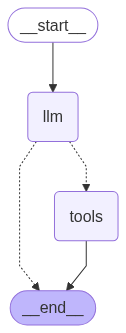

In [19]:
from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

Invoke LLM

In [20]:
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
state = State(messages= HumanMessage(content="Add two number 2 and 5"))

In [21]:
output = graph_builder.invoke(state)

In [22]:
import pprint
for msg in output['messages']:
     msg.pretty_print()

================================ Human Message =================================

Add two number 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (9e8fgrpmw)
 Call ID: 9e8fgrpmw
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7


We can also chain one or more tools togethor

In [23]:
def subtract_two_number(a:int,b:int) -> int:
    """_summary_
     This function subtract two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Subtract two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a-b

def multiply_two_number(a:int,b:int) -> int:
    """_summary_
     This function multiply two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: multiply two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a*b


In [24]:
multiple_tool_graph = StateGraph(State)

In [25]:
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))

In [26]:
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)

In [27]:
graph_builder_multiple_tools = multiple_tool_graph.compile()

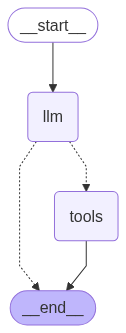

In [28]:
display(Image(graph_builder_multiple_tools.get_graph().draw_mermaid_png()))

In [29]:
state_message = State(messages= HumanMessage(content="Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5"))

In [30]:
result = graph_builder_multiple_tools.invoke(state_message)

In [31]:
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (0x3ddxjz7)
 Call ID: 0x3ddxjz7
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7


Agent without memory

In [32]:
result = graph_builder_multiple_tools.invoke(HumanMessage(content="Add 35 to the previous output"))

BadRequestError: Error code: 400 - {'error': {'message': "'messages' : minimum number of items is 1", 'type': 'invalid_request_error'}}

Agent with memory

In [33]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [40]:
multiple_tool_graph = StateGraph(State)
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)
graph_builder_memory = multiple_tool_graph.compile(checkpointer=memory)

In [39]:
state_message = State(messages= HumanMessage(content="Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5"))

In [41]:
config = {"configurable":{"thread_id":"1"}}

In [42]:
graph_builder_memory.invoke(state_message,config)

{'messages': [HumanMessage(content='Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5', additional_kwargs={}, response_metadata={}, id='06380657-6521-4a3e-a5c7-dcaef806e3ce'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, so I need to figure out how to solve this problem: "Add two numbers, 2 and 5, and then multiply the result by 10 and subtract 5." Let me break it down step by step.\n\nFirst, the user wants me to add two numbers, which are 2 and 5. That seems straightforward. I\'ll call the function `add_two_number` with these two values. So, a is 2 and b is 5. That should give me 7.\n\nNext, after adding 2 and 5, the result is 7. Now, I need to multiply this result by 10. Multiplying 7 by 10 gives me 70.\n\nFinally, I need to subtract 5 from this product. So, 70 minus 5 equals 65.\n\nWait a minute, but looking back at the tools provided, I only have access to the `add_two_number` function. I don\'t have functions for multiplication or

In [55]:
res = graph_builder_memory.invoke(HumanMessage(content="add 25 to that number" ),config)

In [57]:
for item in res['messages']:
  item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (snxzxshxh)
 Call ID: snxzxshxh
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7
================================== Ai Message ==================================
Tool Calls:
  add_two_number (syn1tgjv6)
 Call ID: syn1tgjv6
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7
================================== Ai Message ==================================

The final answer is 65.
================================== Ai Message ==================================
================================== Ai Message ==================================



To solve the problem step 